In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from evaluation import trilateration_centroid, compute_centroid_error, trilateration_centroid_vectorization
from visualization import draw_centroids
from torchvision.transforms import Normalize
import cv2
from conventional_centroiding.threshold_method import centroid_com, detection_globalThreshold, centroiding_CenterOfMass, detection_ST16, centroiding_GaussianGrid, detection_WITM, detection_erosion_dilation

import sys

device = torch.device("cuda:0")
pixel_size = 6/1000
radius = 7

img_np = np.load('nightsky_june16_2021.npy' )
#img_np = cv2.imread('skycam/skycam_1.png', cv2.IMREAD_GRAYSCALE)
center = img_np.shape 
h = 480
w = 640
x = int(center[1]/2 - w/2)
y = int(center[0]/2 - h/2) 
img_np = img_np[y:y+h, x:x+w]

# # for data_straylight
# mean = [44.1619381]
# std =  [60.98225565]

# for data_Oct19
mean = [25.36114133]
std =  [44.31162568]

img = torch.from_numpy(img_np).float()
img = img.to(device)
img = img.unsqueeze(0)
img = img.unsqueeze(0)

# get predictions
#model = torch.load("./saved_models/ELUNet_inter_1.pt")
model = torch.load("./saved_models/2023_models/ELUNet_inter_2_90.pt")
model.eval()

prediction = model(Normalize(mean, std)(img)) # only normalize images for neural network so that conventional centroid can use raw images
seg_prediction = 1.0 * (torch.sigmoid(prediction[0][0]) > 0.5)
seg_prediction = seg_prediction.detach().cpu().numpy()
dist_prediction = prediction[0][1]
dist_prediction = dist_prediction.detach().cpu().numpy()

img = img[0][0].detach().cpu().numpy()

# get estimated centroids: machine learning 
centroid_est = trilateration_centroid(dist_prediction.copy(), seg_prediction.copy(), radius, pixel_size)


# conventional method
mask = detection_erosion_dilation(img.copy(), gaussian_sigma=2, average_window_size=10, detection_sigma=5)
#mask = detection_ST16(img.copy(), threshold=1.5, pixel_area=6, pixel_sum=50)
#centroid_est_2 = centroiding_CenterOfMass(img.copy(), mask, 5)
centroid_est_2 = centroiding_GaussianGrid(img.copy(), mask)




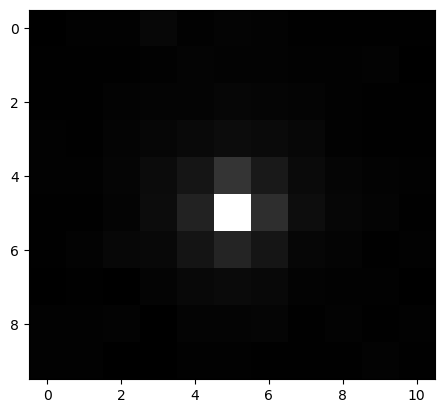

In [3]:
#print( np.floor(np.asarray(centroid_est) / (6/1000.0)) )
"""
    [[ 46.  93.]
    [304. 100.]
    [339. 208.] # bright stars 
    [442. 384.]]
"""
window_width = 5
sub_image = img[209-window_width:209+window_width, 339-window_width:339+window_width+1]
plt.figure(1)
plt.imshow(sub_image, cmap='gray', interpolation='none' )
plt.show()
